In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm  # Progress bar
import dill

from ValueTensor import Value, ValueTensor, criterion
from Layer import initialization, Layer, OutputLayer
from model import FFNN

# Load Dataset

In [2]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
Y = np.eye(10)[y.astype(int)] # one hot encoding untuk output

In [3]:
# normalisasi value
# asumsi dataset tidak berubah
X_normalized = X / 255

In [4]:
# ambil sebagian data set karena terlalu lama
n = 14

X_sliced = X_normalized[:n]
Y_sliced = Y[:n]

In [10]:
# split training and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_sliced, Y_sliced, test_size=1/7, random_state=42)
Y_true_value = np.argmax(Y_val, axis=1)

In [6]:
# untuk lebih mudah plotting hasil akhir (grafik training loss dan validation loss)

def plot_loss(train_l, val_l):
    # kedua input berbentuk array
    e = np.arange(1, len(train_l)+1) 

    plt.figure(figsize=(8, 5))
    plt.plot(e, train_l, marker='o', label='Training loss')
    plt.plot(e, val_l, marker='s', label='Validation loss')

    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Grafik Loss setiap epoch")
    plt.legend()
    plt.grid()
    plt.show()

# Test save and load model

In [7]:
ModelSigmaSkibidi = FFNN(2, [3, 4, 5], 10, ["linear", "relu", "sigmoid", "softmax"], "mse", [("zero", -1, 1, 42, "he") for _ in range (4)])
ModelSigmaSkibidi.save_model("mokel.pkl")

Model saved to mokel.pkl


In [14]:
ModelHawkTuah = FFNN.load_model("mokel.pkl")
print(ModelHawkTuah.input_size)
print(ModelHawkTuah.hidden_size_array)
print(ModelHawkTuah.output_size)
print(ModelHawkTuah.num_neurons)
print(ModelHawkTuah.activation_function)
print(ModelHawkTuah.loss_function)
print(ModelHawkTuah.weight_init)
print(ModelHawkTuah.input_and_hidden_layers[0].weights)

Model loaded from mokel.pkl
2
[3 4 5]
10
[ 2  3  4  5 10]
['linear', 'relu', 'sigmoid', 'softmax']
mse
[('zero', -1, 1, 42, 'he'), ('zero', -1, 1, 42, 'he'), ('zero', -1, 1, 42, 'he'), ('zero', -1, 1, 42, 'he')]
ValueTensor(
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]])


# Test pengaruh depth

Epoch 1/3: 100%|██████████| 7/7 [00:08<00:00,  1.14s/batch, Batch Loss=0.0991]


Epoch 1: Train Loss = 0.0921083687716709, Val Loss = 0.08314119473574678


Epoch 2/3: 100%|██████████| 7/7 [00:17<00:00,  2.50s/batch, Batch Loss=0.0984]


Epoch 2: Train Loss = 0.09155377353328704, Val Loss = 0.08354681328489083


Epoch 3/3: 100%|██████████| 7/7 [00:28<00:00,  4.01s/batch, Batch Loss=0.0977]

Epoch 3: Train Loss = 0.09106108577456, Val Loss = 0.08398548016912
Prediksi: [3 3]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


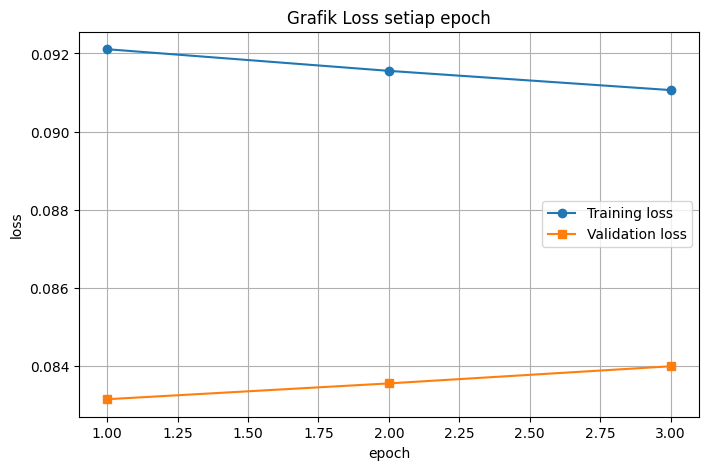

In [11]:
# 3 hidden layer
Depth1 = FFNN(784, [3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = Depth1.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = Depth1.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)

Epoch 1/3:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 1/3: 100%|██████████| 7/7 [00:11<00:00,  1.66s/batch, Batch Loss=0.099] 


Epoch 1: Train Loss = 0.09215683649636873, Val Loss = 0.08323398418715255


Epoch 2/3: 100%|██████████| 7/7 [00:29<00:00,  4.22s/batch, Batch Loss=0.0983]


Epoch 2: Train Loss = 0.09158813245870534, Val Loss = 0.08364991648893108


Epoch 3/3: 100%|██████████| 7/7 [00:43<00:00,  6.16s/batch, Batch Loss=0.0976]

Epoch 3: Train Loss = 0.09108401236005337, Val Loss = 0.08410058349599406
Prediksi: [3 3]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


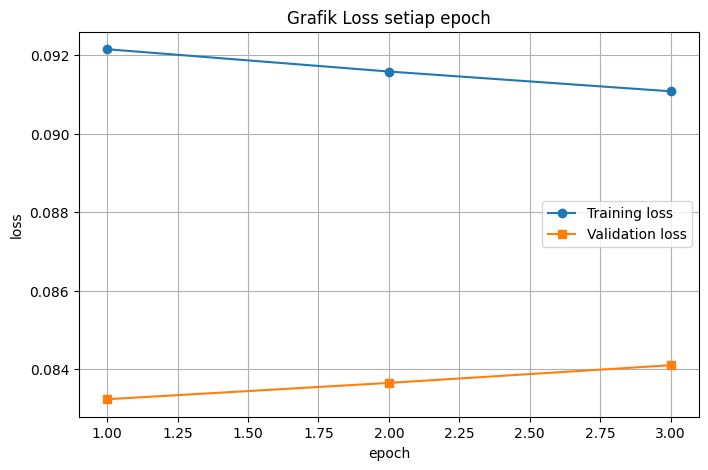

In [12]:
# 5 hidden layer
Depth2 = FFNN(784, [3, 3, 3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (6)])
train_loss, val_loss = Depth2.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = Depth2.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)

Epoch 1/3: 100%|██████████| 7/7 [00:08<00:00,  1.25s/batch, Batch Loss=0.099] 


Epoch 1: Train Loss = 0.09214867679175547, Val Loss = 0.08323106827736693


Epoch 2/3: 100%|██████████| 7/7 [00:36<00:00,  5.18s/batch, Batch Loss=0.0983]


Epoch 2: Train Loss = 0.09158047249309036, Val Loss = 0.08364654413717598


Epoch 3/3: 100%|██████████| 7/7 [01:27<00:00, 12.51s/batch, Batch Loss=0.0976]


Epoch 3: Train Loss = 0.09107672256589666, Val Loss = 0.08409671896134481
Prediksi: [3 3]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


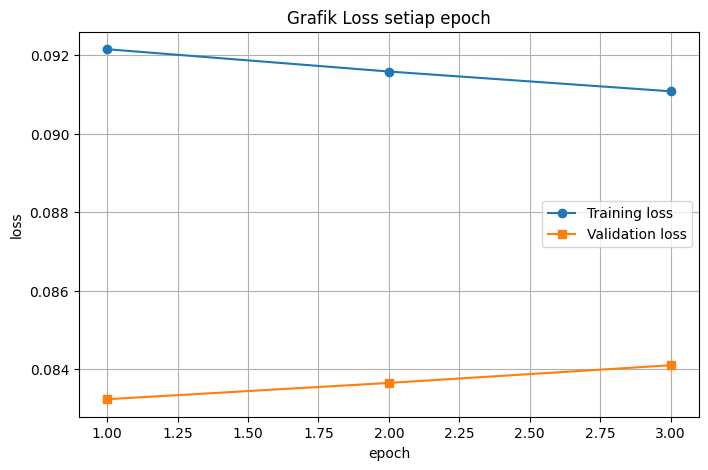

In [13]:
# 7 hidden layer
Depth3 = FFNN(784, [3, 3, 3, 3, 3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (8)])
train_loss, val_loss = Depth3.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = Depth3.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)

# Test pengaruh width

Epoch 1/3:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 1/3: 100%|██████████| 7/7 [00:06<00:00,  1.03batch/s, Batch Loss=0.099] 


Epoch 1: Train Loss = 0.09212487070291249, Val Loss = 0.08323810860825918


Epoch 2/3: 100%|██████████| 7/7 [00:30<00:00,  4.33s/batch, Batch Loss=0.0983]


Epoch 2: Train Loss = 0.09155579033840948, Val Loss = 0.08365327755235481


Epoch 3/3: 100%|██████████| 7/7 [00:36<00:00,  5.23s/batch, Batch Loss=0.0976]


Epoch 3: Train Loss = 0.0910511868653442, Val Loss = 0.08410334571688446
Prediksi: [3 3]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


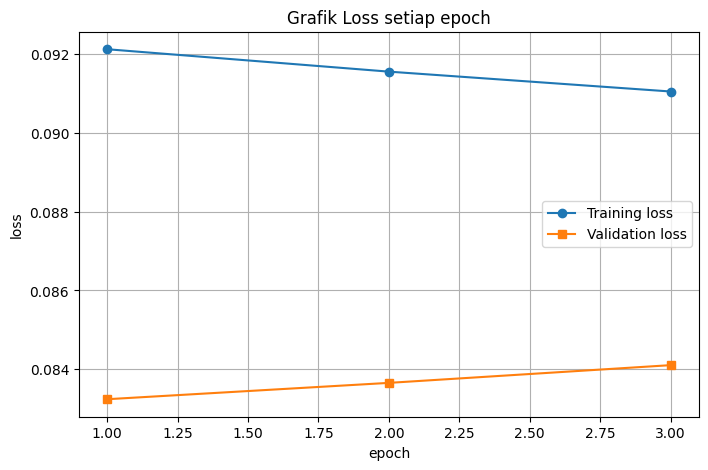

In [14]:
# 3 neuron per layer
Width1 = FFNN(784, [3, 3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (5)])
train_loss, val_loss = Width1.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = Width1.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)

Epoch 1/3:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 1/3: 100%|██████████| 7/7 [00:37<00:00,  5.31s/batch, Batch Loss=0.0914]


Epoch 1: Train Loss = 0.08936148002562942, Val Loss = 0.08589163035171303


Epoch 2/3: 100%|██████████| 7/7 [00:34<00:00,  4.90s/batch, Batch Loss=0.0898]


Epoch 2: Train Loss = 0.08871481511759417, Val Loss = 0.0870590425786256


Epoch 3/3: 100%|██████████| 7/7 [01:06<00:00,  9.51s/batch, Batch Loss=0.0883]

Epoch 3: Train Loss = 0.0882031098154221, Val Loss = 0.08808456346098337
Prediksi: [3 3]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


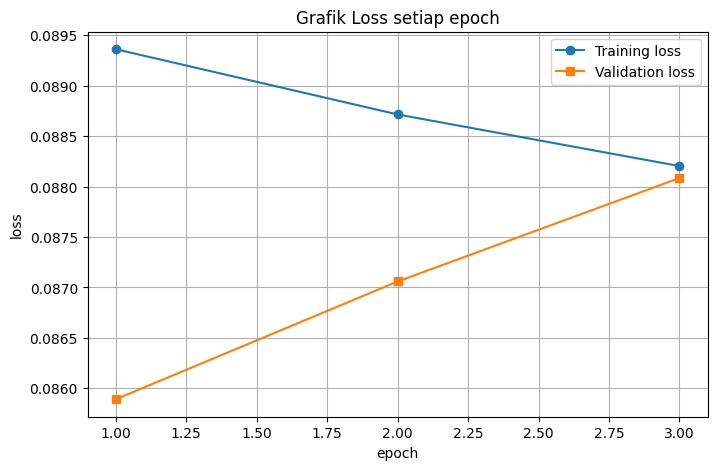

In [15]:
# 5 neuron per layer
Width2 = FFNN(784, [5, 5, 5, 5], 10, ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (5)])
train_loss, val_loss = Width2.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = Width2.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)

Epoch 1/3: 100%|██████████| 7/7 [00:23<00:00,  3.29s/batch, Batch Loss=0.0897]


Epoch 1: Train Loss = 0.08987954253273805, Val Loss = 0.08732621847711924


Epoch 2/3: 100%|██████████| 7/7 [01:27<00:00, 12.51s/batch, Batch Loss=0.0853]


Epoch 2: Train Loss = 0.08901155082184069, Val Loss = 0.08753103307976963


Epoch 3/3: 100%|██████████| 7/7 [02:38<00:00, 22.57s/batch, Batch Loss=0.0819]


Epoch 3: Train Loss = 0.08845229281342311, Val Loss = 0.08809890000997944
Prediksi: [3 3]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


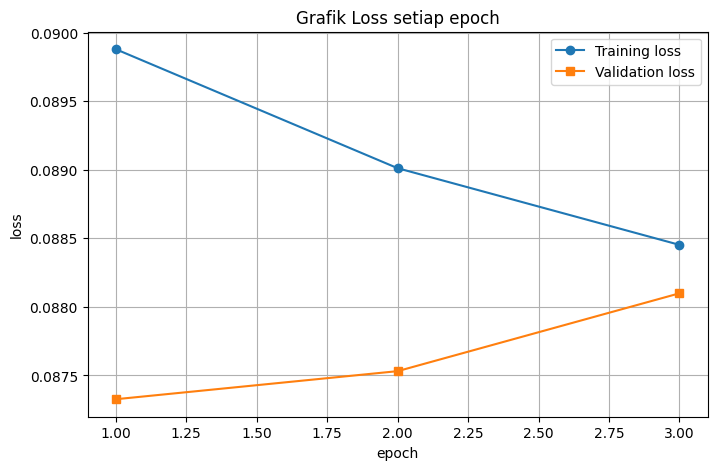

In [16]:
# 10 neuron per layer
Width3 = FFNN(784, [10, 10, 10, 10], 10, ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (5)])
train_loss, val_loss = Width3.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = Width3.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)

# Test pengaruh fungsi aktivasi

Epoch 1/3: 100%|██████████| 7/7 [00:04<00:00,  1.46batch/s, Batch Loss=0.124] 


Epoch 1: Train Loss = 0.10693057737012668, Val Loss = 0.09793764013254347


Epoch 2/3: 100%|██████████| 7/7 [00:16<00:00,  2.33s/batch, Batch Loss=0.079] 


Epoch 2: Train Loss = 0.09950221244961073, Val Loss = 0.17779882424560506


Epoch 3/3:  43%|████▎     | 3/7 [00:07<00:10,  2.65s/batch, Batch Loss=0.2]c:\Users\devin\Tubes_ML_1\src\ValueTensor.py:130: RuntimeWarning: overflow encountered in exp
  out = Value(np.exp(self.data), (self,), "e**")
c:\Users\devin\Tubes_ML_1\src\ValueTensor.py:26: RuntimeWarning: invalid value encountered in scalar multiply
  out = Value(self.data * other.data, (self, other), "*")
Epoch 3/3:  57%|█████▋    | 4/7 [00:11<00:09,  3.18s/batch, Batch Loss=nan]c:\Users\devin\Tubes_ML_1\src\ValueTensor.py:55: RuntimeWarning: invalid value encountered in scalar multiply
  self.grad += other * (self.data**(other - 1)) * out.grad
c:\Users\devin\Tubes_ML_1\src\ValueTensor.py:133: RuntimeWarning: invalid value encountered in scalar multiply
  self.grad += out.data * out.grad
Epoch 3/3: 100%|██████████| 7/7 [00:24<00:00,  3.56s/batch, Batch Loss=nan]

Epoch 3: Train Loss = nan, Val Loss = nan
Prediksi: [0 0]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


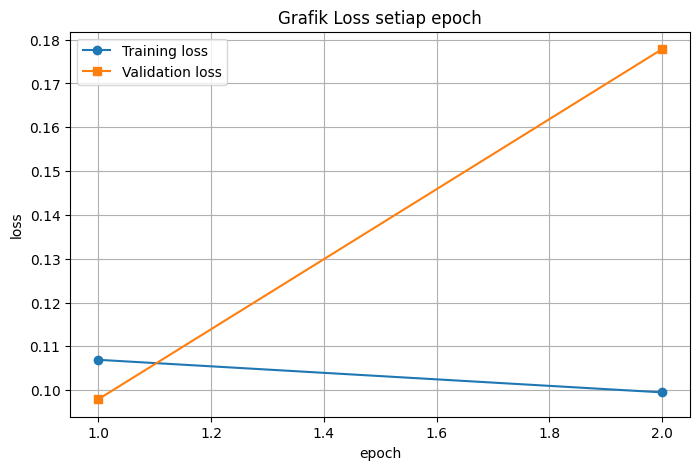

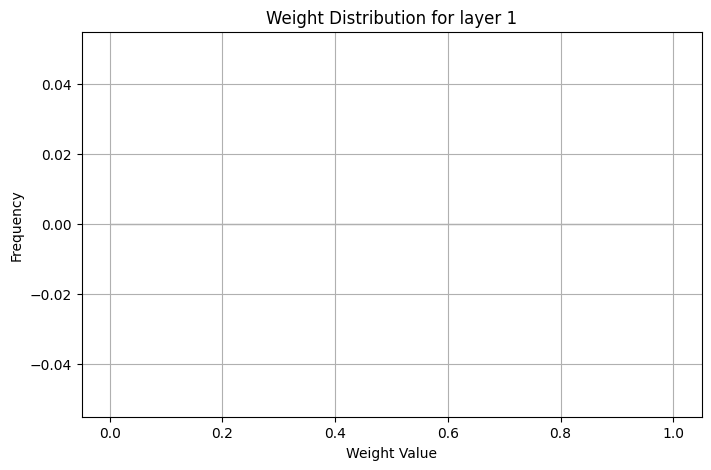

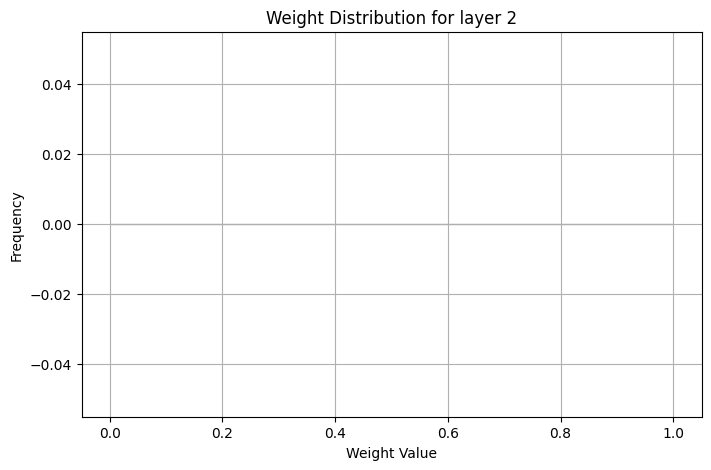

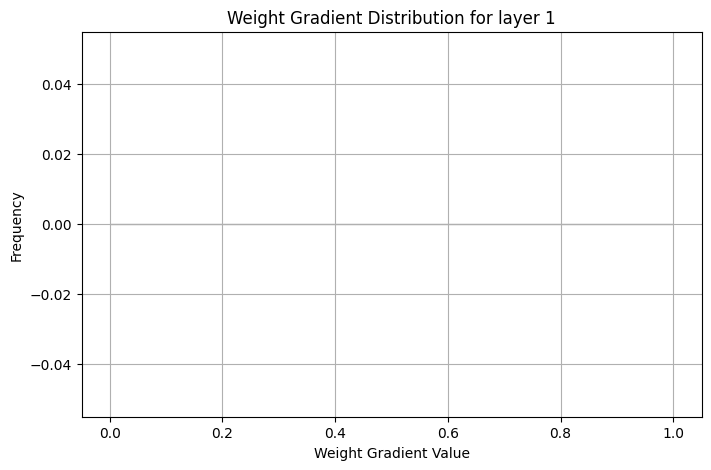

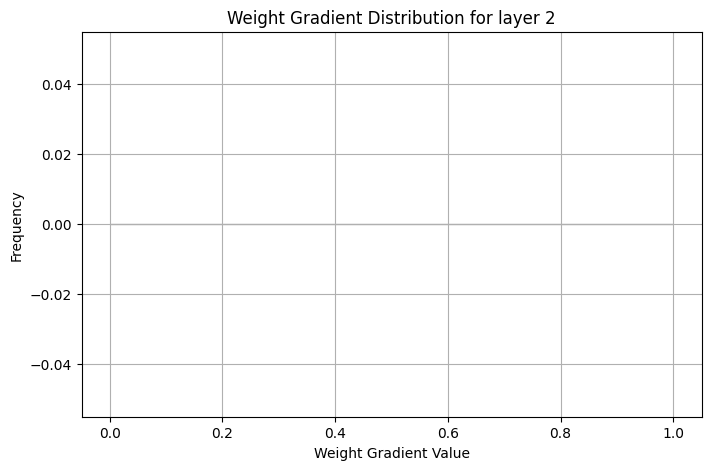

In [17]:
# linear
fn_linear = FFNN(784, [3, 3, 3], 10, ["linear", "linear", "linear", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = fn_linear.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = fn_linear.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
fn_linear.weight_distribution([1, 2])
fn_linear.gradient_distribution([1, 2])

Epoch 1/3: 100%|██████████| 7/7 [00:40<00:00,  5.77s/batch, Batch Loss=0.105] 


Epoch 1: Train Loss = 0.09104348740893792, Val Loss = 0.07627112389732069


Epoch 2/3: 100%|██████████| 7/7 [00:13<00:00,  1.98s/batch, Batch Loss=0.105] 


Epoch 2: Train Loss = 0.09017589316689197, Val Loss = 0.0791265562896312


Epoch 3/3: 100%|██████████| 7/7 [00:22<00:00,  3.23s/batch, Batch Loss=0.103] 

Epoch 3: Train Loss = 0.08926340338516918, Val Loss = 0.07936097774095742
Prediksi: [3 3]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


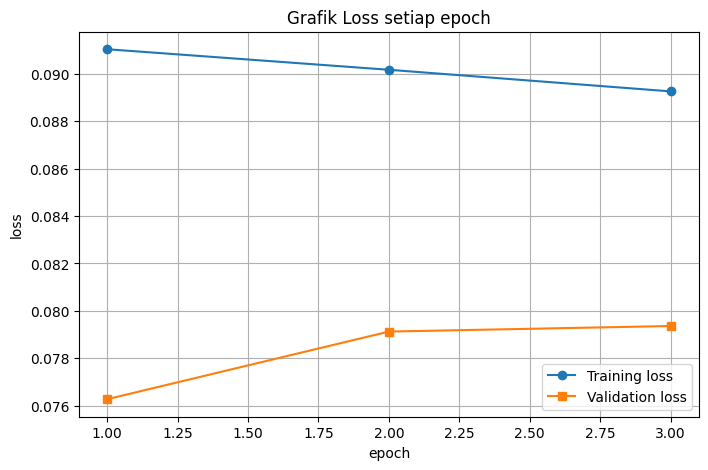

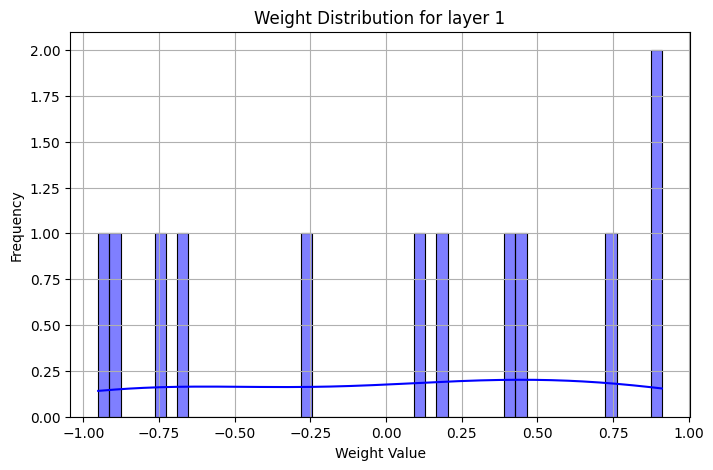

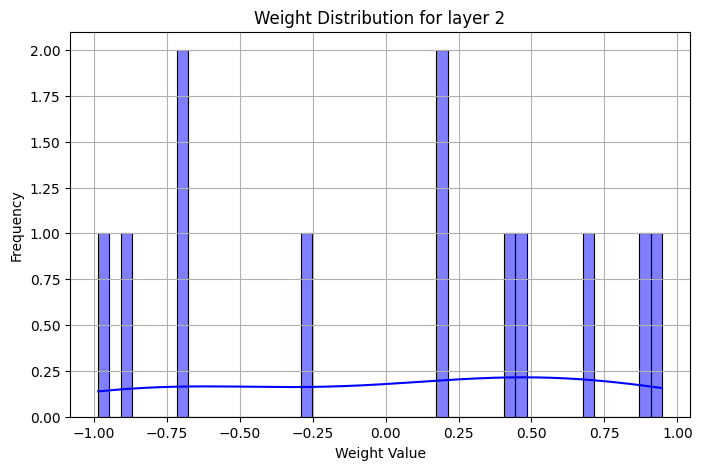

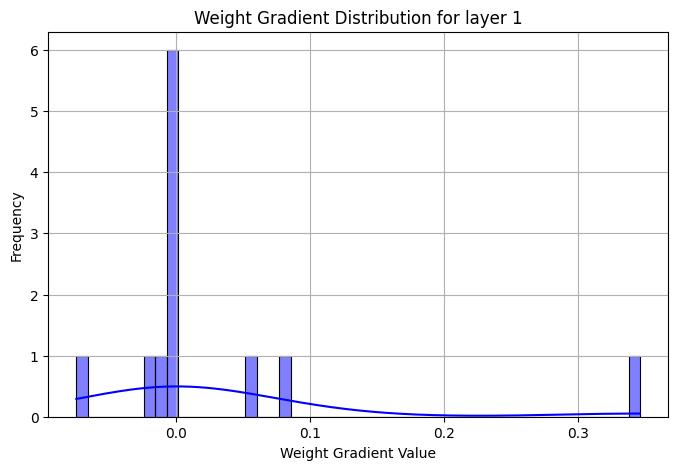

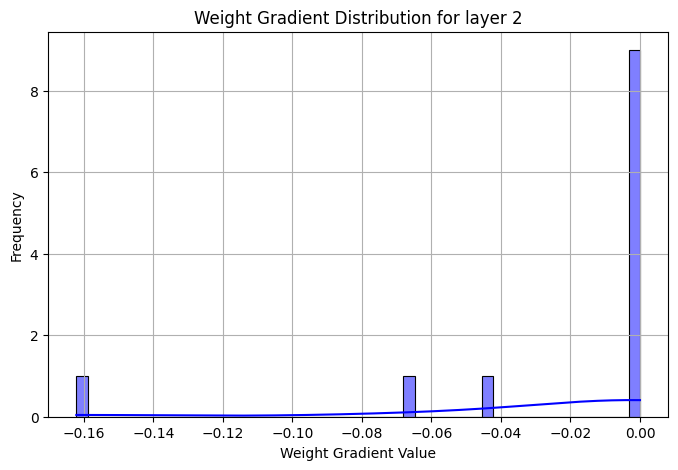

In [18]:
# relu
fn_relu = FFNN(784, [3, 3, 3], 10, ["relu", "relu", "relu", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = fn_relu.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = fn_relu.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
fn_relu.weight_distribution([1, 2])
fn_relu.gradient_distribution([1, 2])

Epoch 1/3: 100%|██████████| 7/7 [00:05<00:00,  1.39batch/s, Batch Loss=0.0991]


Epoch 1: Train Loss = 0.0921083687716709, Val Loss = 0.08314119473574678


Epoch 2/3: 100%|██████████| 7/7 [00:15<00:00,  2.24s/batch, Batch Loss=0.0984]


Epoch 2: Train Loss = 0.09155377353328704, Val Loss = 0.08354681328489083


Epoch 3/3: 100%|██████████| 7/7 [00:28<00:00,  4.02s/batch, Batch Loss=0.0977]

Epoch 3: Train Loss = 0.09106108577456, Val Loss = 0.08398548016912
Prediksi: [3 3]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


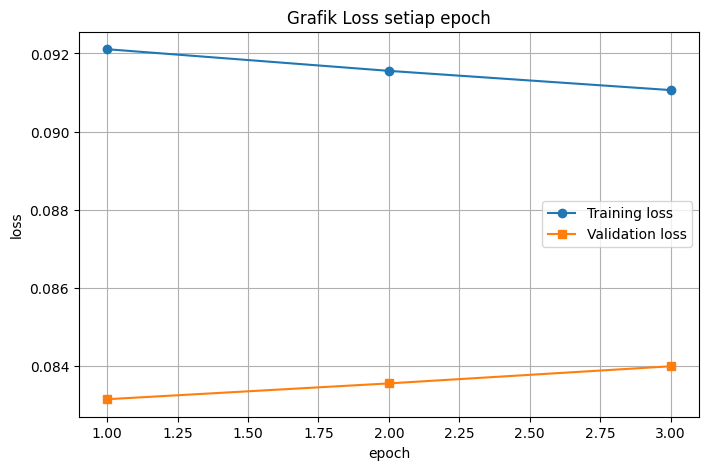

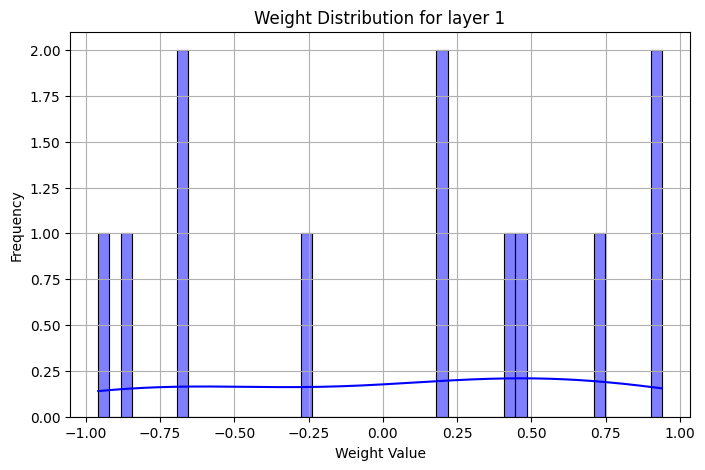

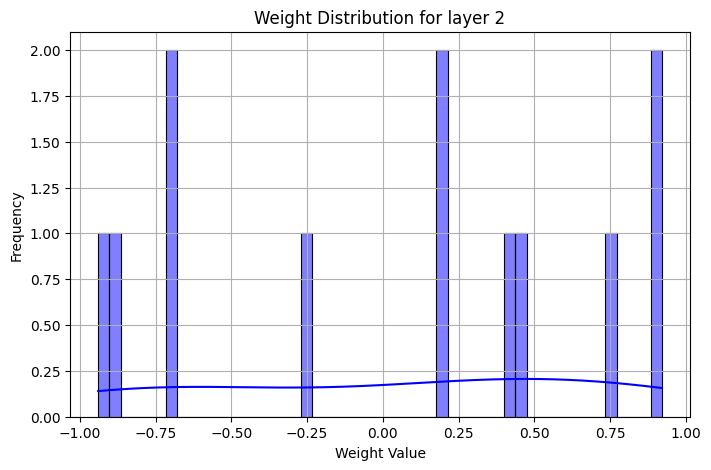

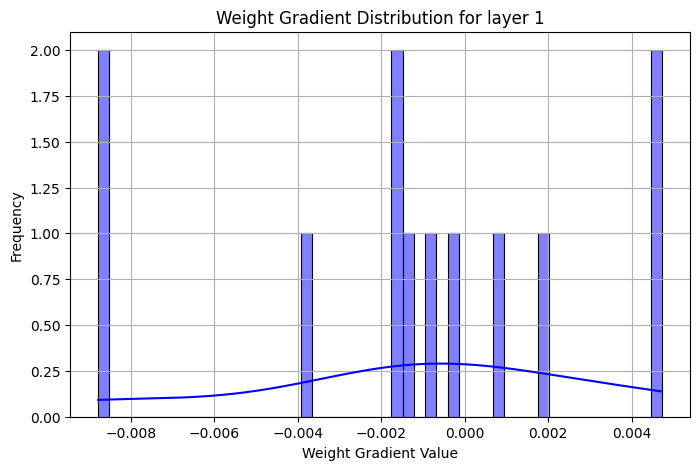

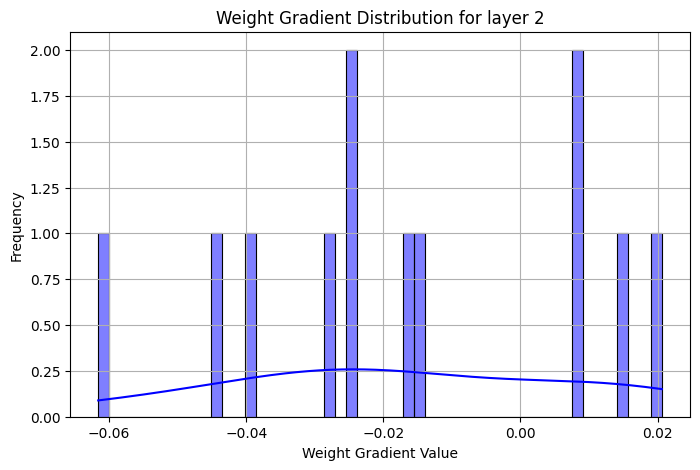

In [19]:
# sigmoid
fn_sigmoid = FFNN(784, [3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = fn_sigmoid.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = fn_sigmoid.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
fn_sigmoid.weight_distribution([1, 2])
fn_sigmoid.gradient_distribution([1, 2])

Epoch 1/3:  57%|█████▋    | 4/7 [00:01<00:01,  1.84batch/s, Batch Loss=0.0914]c:\Users\devin\Tubes_ML_1\src\ValueTensor.py:215: RuntimeWarning: overflow encountered in exp
  out = Value((np.exp(self.data) - np.exp(-self.data)) \
c:\Users\devin\Tubes_ML_1\src\ValueTensor.py:216: RuntimeWarning: overflow encountered in exp
  / (np.exp(self.data) + np.exp(-self.data)),
c:\Users\devin\Tubes_ML_1\src\ValueTensor.py:215: RuntimeWarning: invalid value encountered in scalar divide
  out = Value((np.exp(self.data) - np.exp(-self.data)) \
C:\Users\devin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
Epoch 1/3:  71%|███████▏  | 5/7 [00:03<00:01,  1.24batch/s, Batch Loss=nan]   c:\Users\devin\Tubes_ML_1\src\ValueTensor.py:220: RuntimeWarning: overflow encountered in exp
  self.grad += (2/(np

Epoch 1: Train Loss = nan, Val Loss = nan


Epoch 2/3: 100%|██████████| 7/7 [01:49<00:00, 15.69s/batch, Batch Loss=nan]


Epoch 2: Train Loss = nan, Val Loss = nan


Epoch 3/3: 100%|██████████| 7/7 [00:23<00:00,  3.40s/batch, Batch Loss=nan]

Epoch 3: Train Loss = nan, Val Loss = nan
Prediksi: [0 0]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


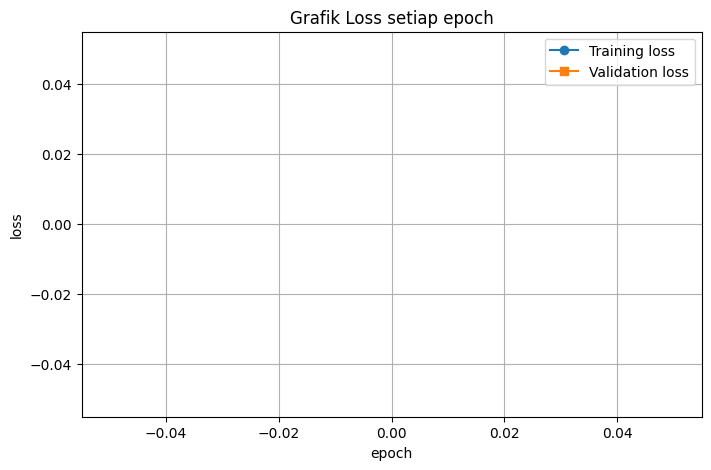

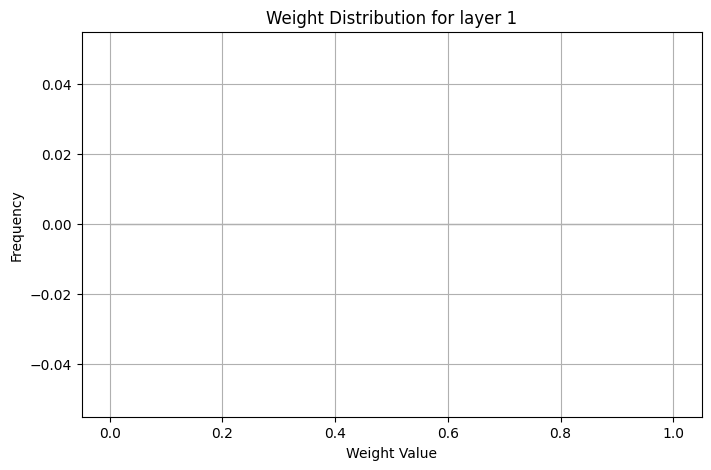

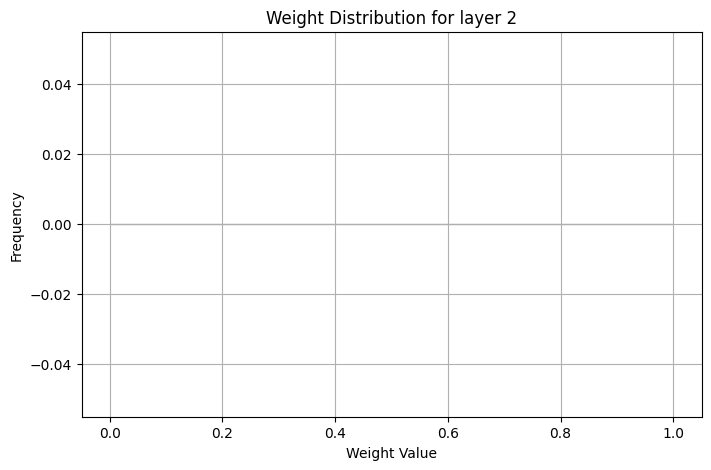

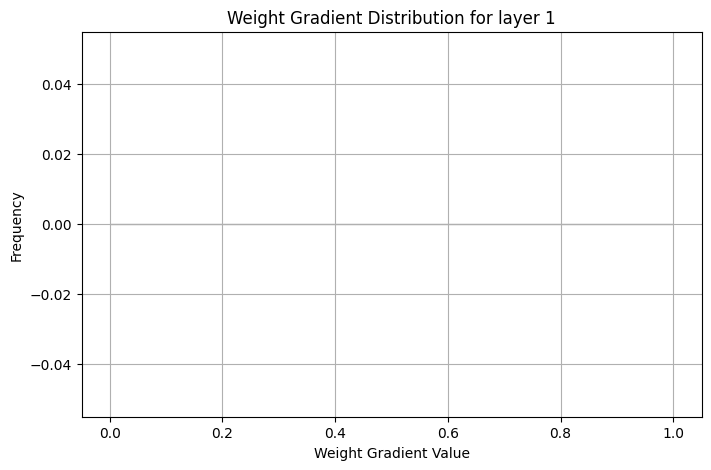

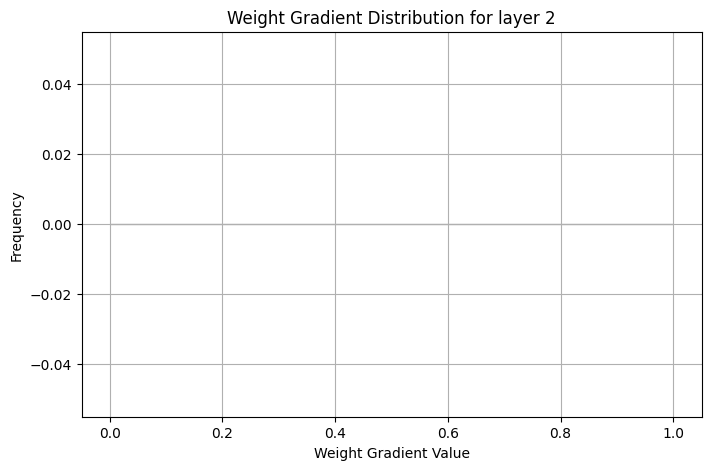

In [20]:
# tanh
fn_tanh = FFNN(784, [3, 3, 3], 10, ["tanh", "tanh", "tanh", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = fn_tanh.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = fn_tanh.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
fn_tanh.weight_distribution([1, 2])
fn_tanh.gradient_distribution([1, 2])

# Test pengaruh learning rate

Epoch 1/3: 100%|██████████| 7/7 [00:05<00:00,  1.25batch/s, Batch Loss=0.0993]


Epoch 1: Train Loss = 0.092095786393297, Val Loss = 0.08282030242498653


Epoch 2/3: 100%|██████████| 7/7 [00:16<00:00,  2.38s/batch, Batch Loss=0.0992]


Epoch 2: Train Loss = 0.09203294705208355, Val Loss = 0.0828524811986743


Epoch 3/3: 100%|██████████| 7/7 [00:33<00:00,  4.83s/batch, Batch Loss=0.0991]


Epoch 3: Train Loss = 0.09197092415688214, Val Loss = 0.0828854334040114
Prediksi: [3 3]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


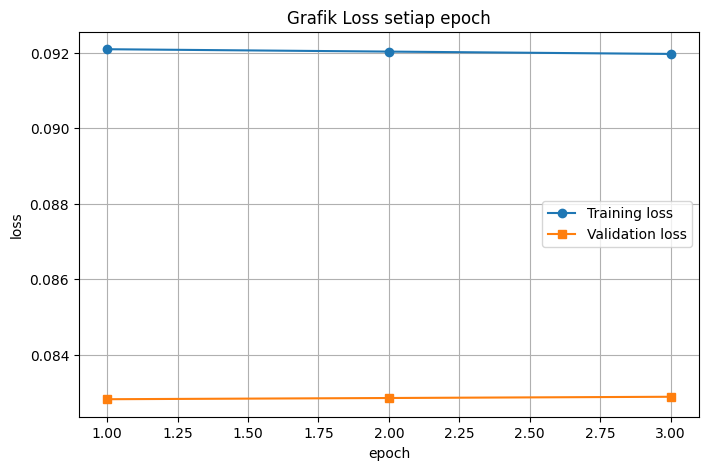

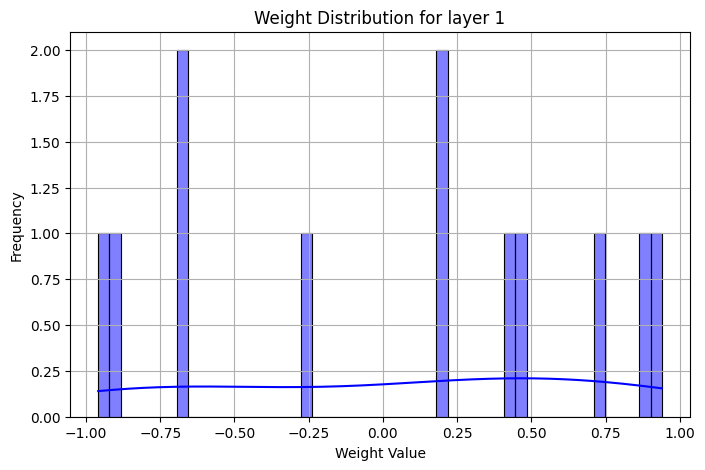

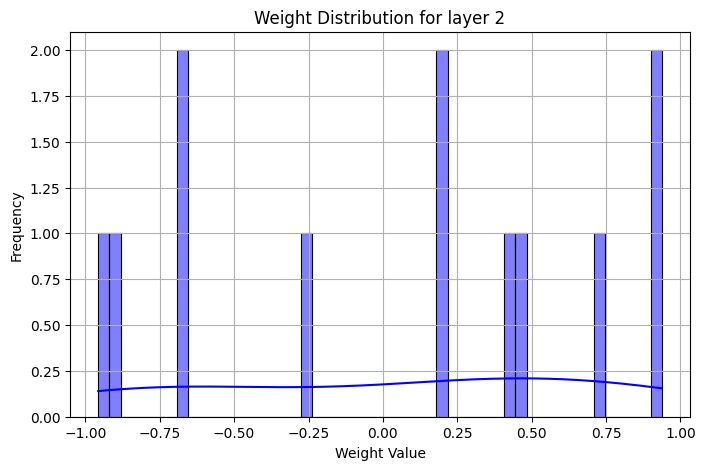

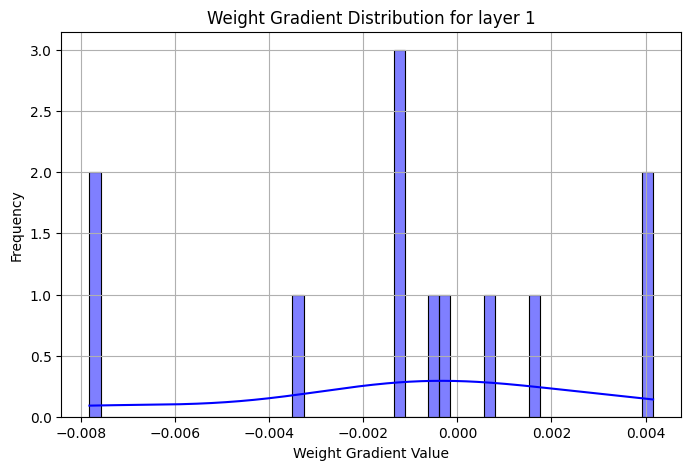

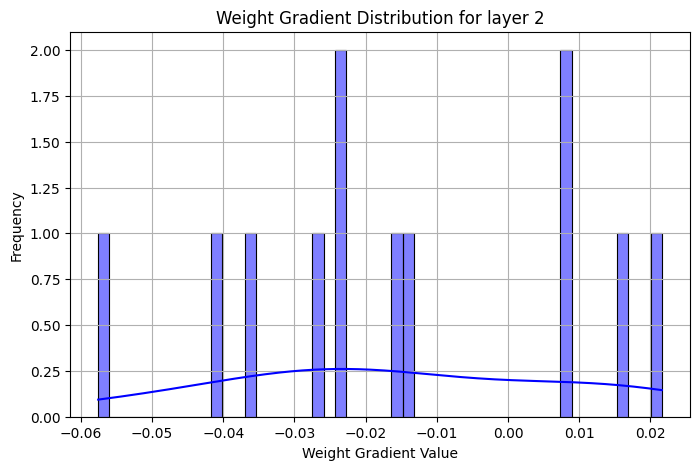

In [21]:
# 0.01
Learn1 = FFNN(784, [3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = Learn1.train_model(2, 0.01, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = Learn1.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Learn1.weight_distribution([1, 2])
Learn1.gradient_distribution([1, 2])

Epoch 1/3:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 1/3: 100%|██████████| 7/7 [00:10<00:00,  1.49s/batch, Batch Loss=0.0991]


Epoch 1: Train Loss = 0.0921083687716709, Val Loss = 0.08314119473574678


Epoch 2/3: 100%|██████████| 7/7 [00:31<00:00,  4.50s/batch, Batch Loss=0.0984]


Epoch 2: Train Loss = 0.09155377353328704, Val Loss = 0.08354681328489083


Epoch 3/3: 100%|██████████| 7/7 [00:49<00:00,  7.07s/batch, Batch Loss=0.0977]


Epoch 3: Train Loss = 0.09106108577456, Val Loss = 0.08398548016912
Prediksi: [3 3]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


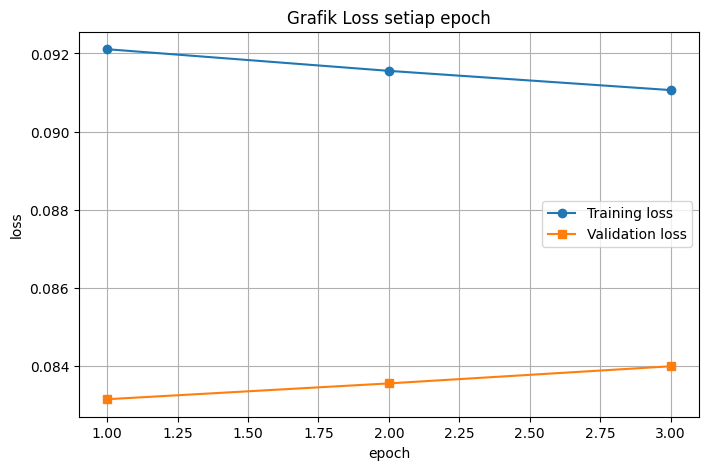

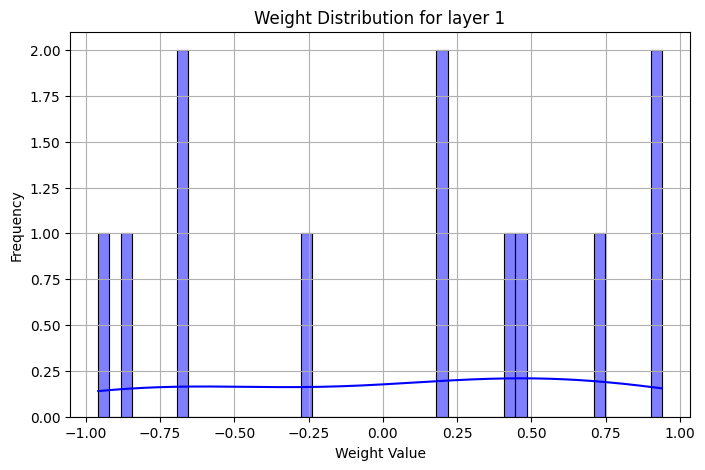

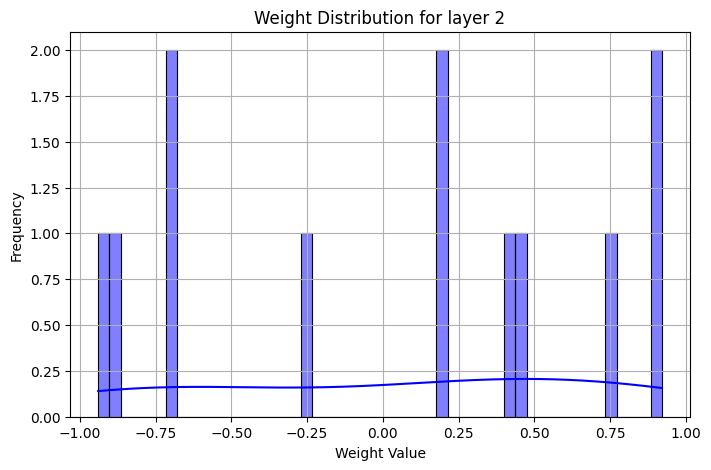

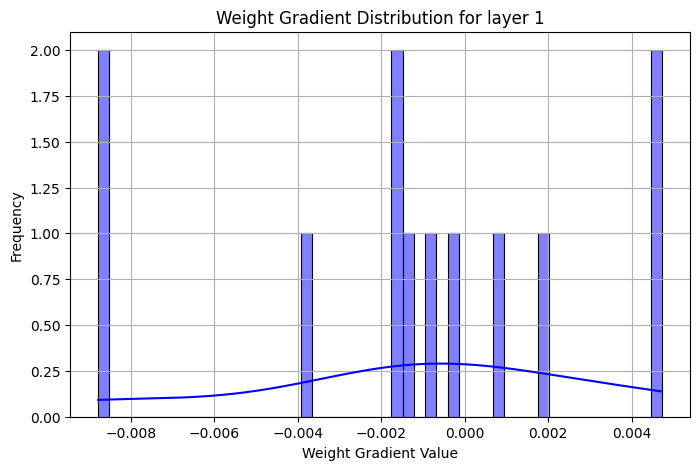

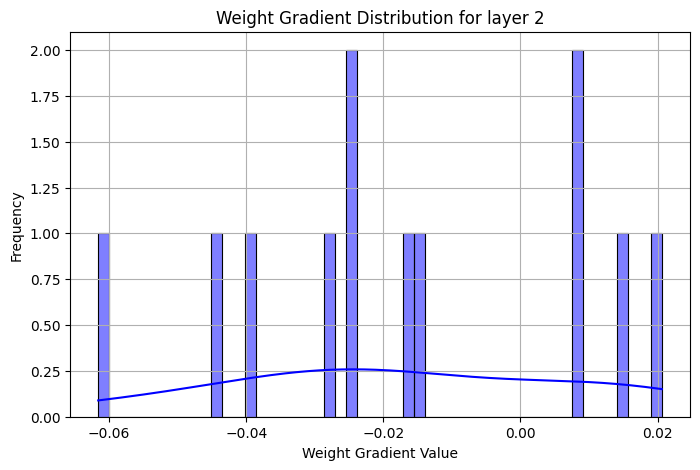

In [22]:
# 0.1
Learn2 = FFNN(784, [3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = Learn2.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = Learn2.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Learn2.weight_distribution([1, 2])
Learn2.gradient_distribution([1, 2])

Epoch 1/3: 100%|██████████| 7/7 [00:10<00:00,  1.46s/batch, Batch Loss=0.0856]


Epoch 1: Train Loss = 0.10207921036038592, Val Loss = 0.1722606446717574


Epoch 2/3: 100%|██████████| 7/7 [02:37<00:00, 22.44s/batch, Batch Loss=0.122] 


Epoch 2: Train Loss = 0.1169294546725927, Val Loss = 0.087787278010211


Epoch 3/3: 100%|██████████| 7/7 [00:24<00:00,  3.50s/batch, Batch Loss=0.126]


Epoch 3: Train Loss = 0.11784267886334687, Val Loss = 0.13369239915535866
Prediksi: [3 3]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


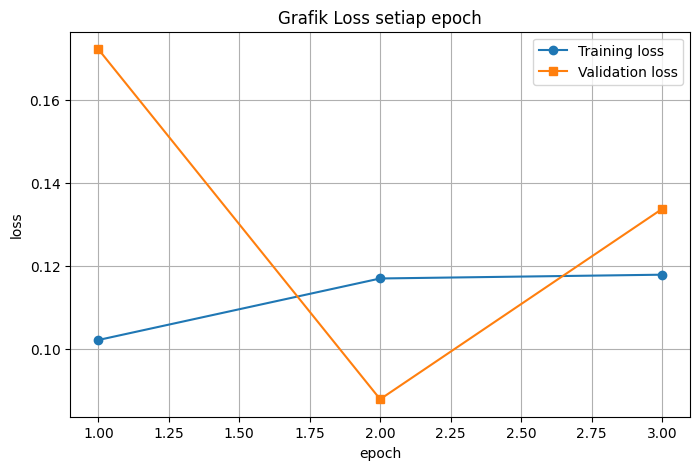

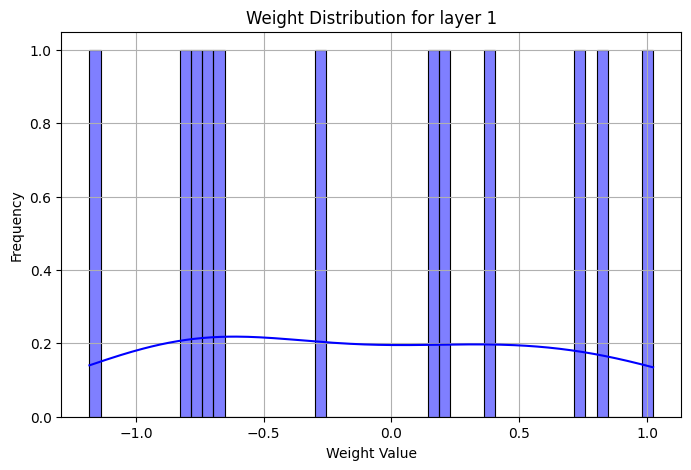

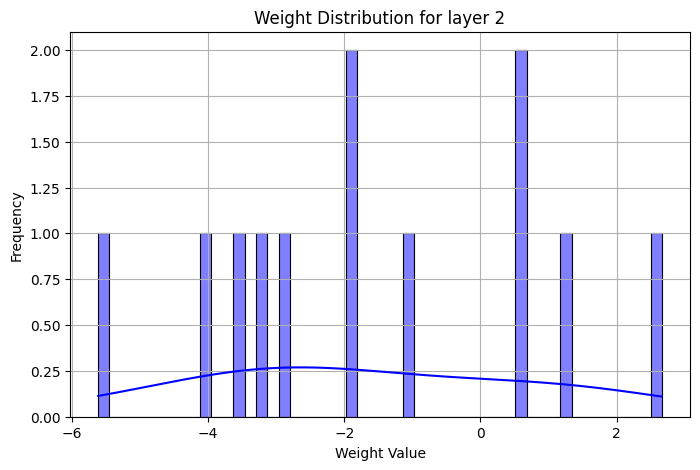

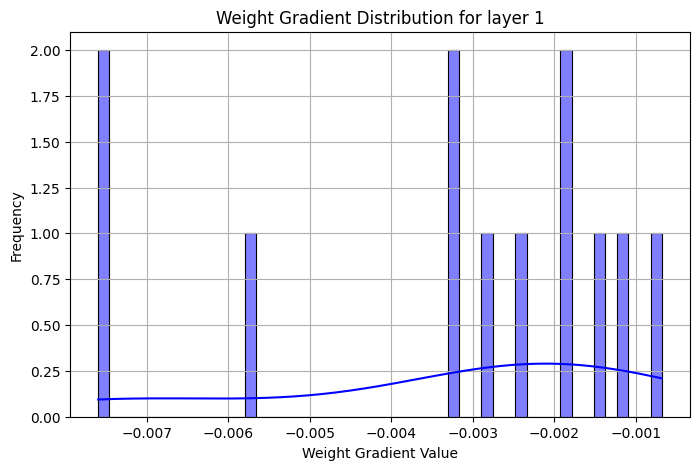

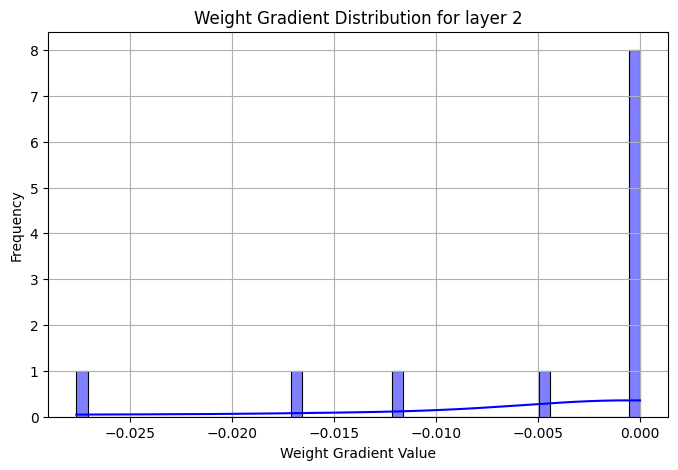

In [23]:
# 10
Learn3 = FFNN(784, [3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = Learn3.train_model(2, 10, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = Learn3.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Learn3.weight_distribution([1, 2])
Learn3.gradient_distribution([1, 2])

# Test pengaruh inisialisasi bobot

Epoch 1/3: 100%|██████████| 7/7 [00:05<00:00,  1.17batch/s, Batch Loss=0.09]  


Epoch 1: Train Loss = 0.09005984878691004, Val Loss = 0.09007803470698969


Epoch 2/3: 100%|██████████| 7/7 [00:17<00:00,  2.49s/batch, Batch Loss=0.0894]


Epoch 2: Train Loss = 0.08979105329206873, Val Loss = 0.09017105687745927


Epoch 3/3: 100%|██████████| 7/7 [00:29<00:00,  4.22s/batch, Batch Loss=0.0888]


Epoch 3: Train Loss = 0.08952616874469667, Val Loss = 0.0902787202551108
Prediksi: [1 1]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


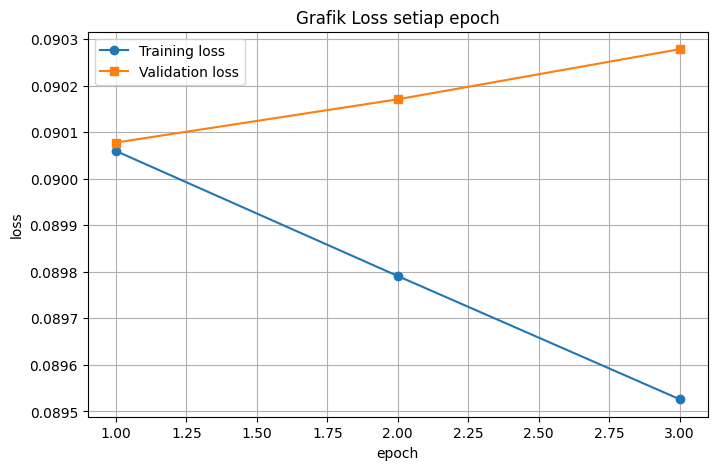

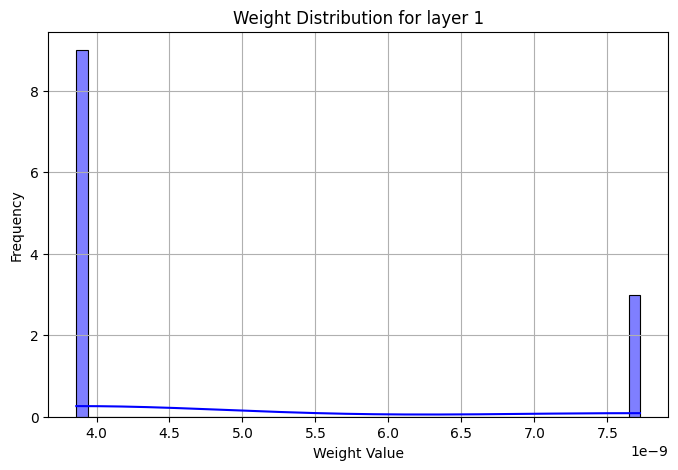

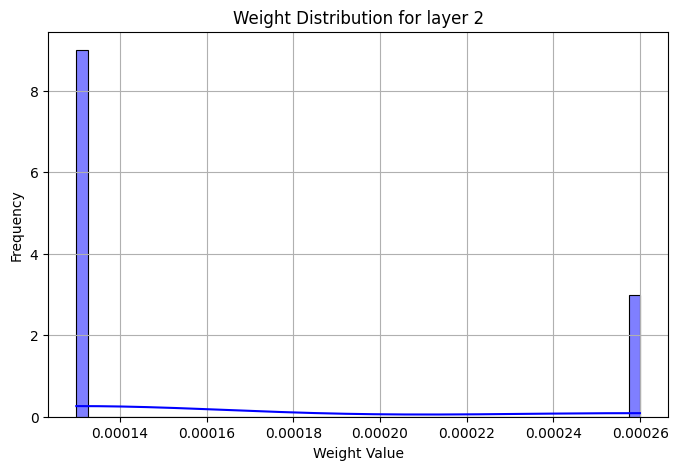

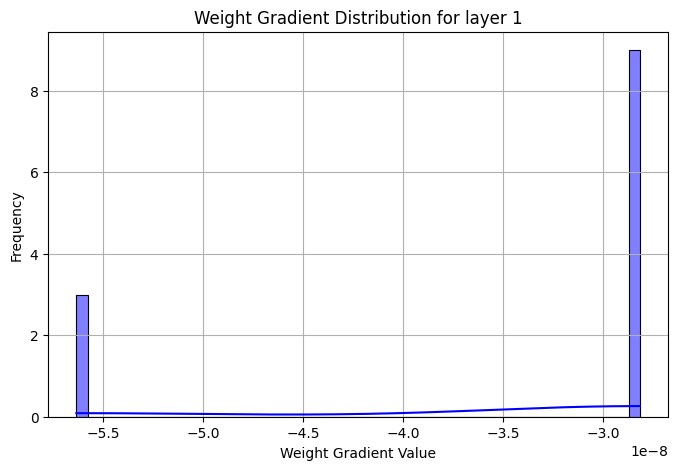

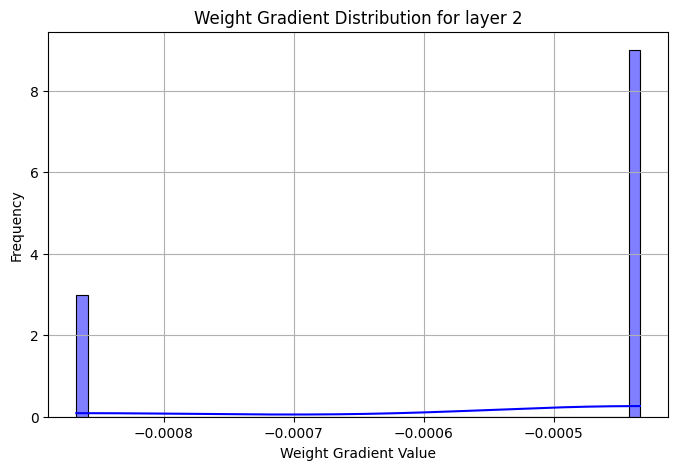

In [24]:
# zero
Weight1 = FFNN(784, [3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("zero", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = Weight1.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = Weight1.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Weight1.weight_distribution([1, 2])
Weight1.gradient_distribution([1, 2])

Epoch 1/3: 100%|██████████| 7/7 [00:05<00:00,  1.18batch/s, Batch Loss=0.0991]


Epoch 1: Train Loss = 0.0921083687716709, Val Loss = 0.08314119473574678


Epoch 2/3: 100%|██████████| 7/7 [00:17<00:00,  2.51s/batch, Batch Loss=0.0984]


Epoch 2: Train Loss = 0.09155377353328704, Val Loss = 0.08354681328489083


Epoch 3/3: 100%|██████████| 7/7 [00:22<00:00,  3.25s/batch, Batch Loss=0.0977]

Epoch 3: Train Loss = 0.09106108577456, Val Loss = 0.08398548016912
Prediksi: [3 3]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


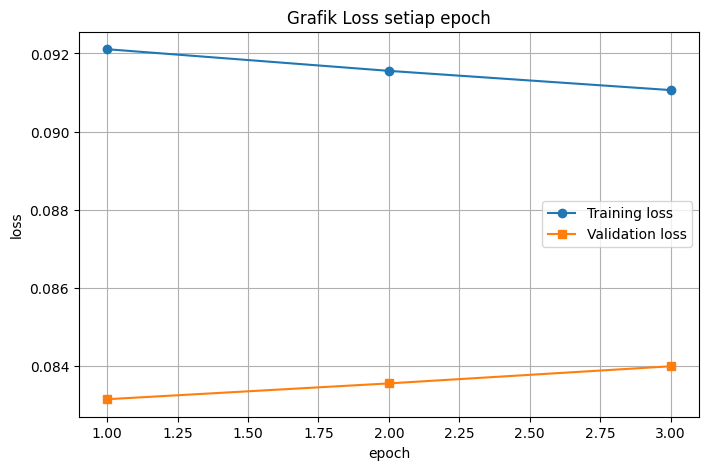

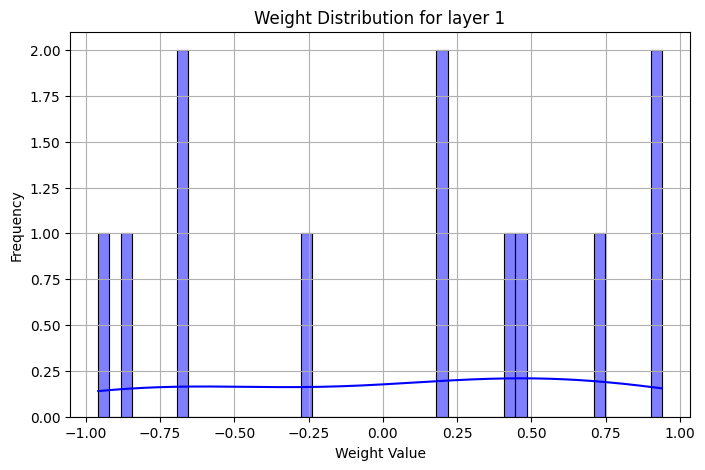

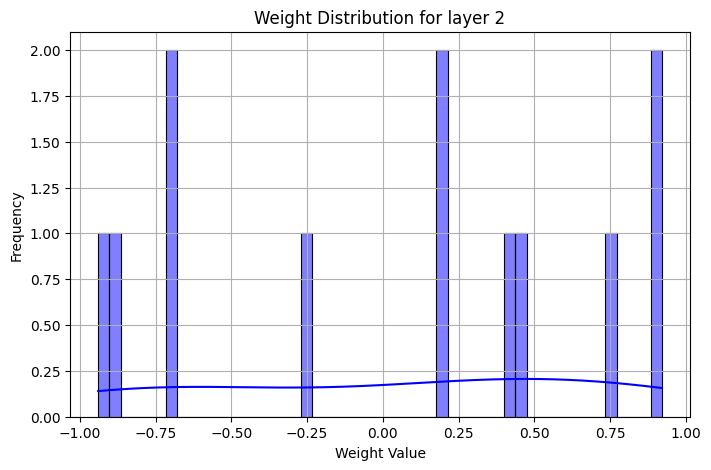

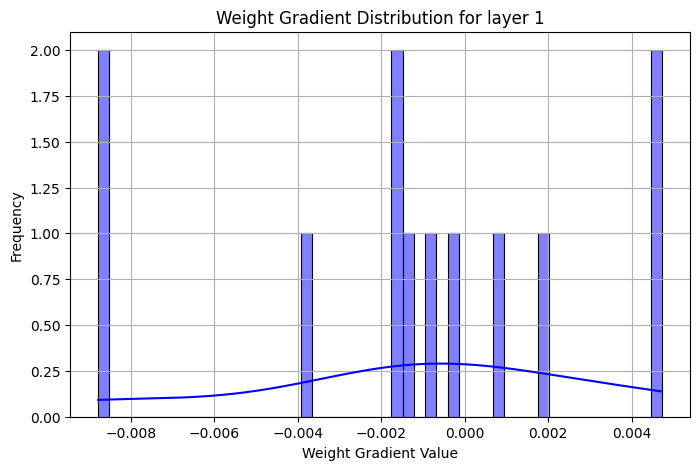

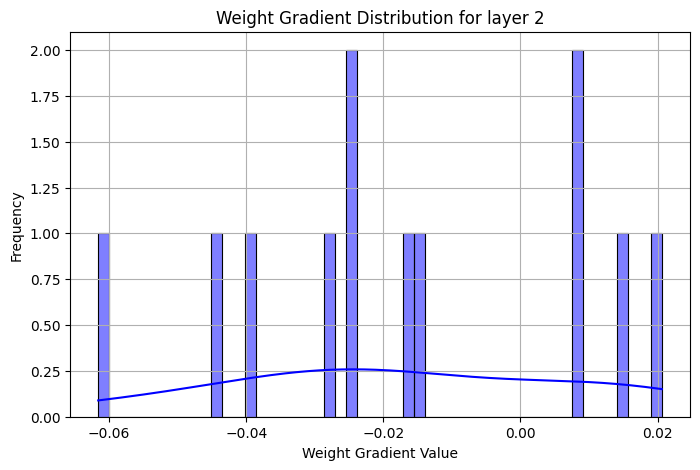

In [25]:
# uniform
Weight2 = FFNN(784, [3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = Weight2.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = Weight2.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Weight2.weight_distribution([1, 2])
Weight2.gradient_distribution([1, 2])

Epoch 1/3: 100%|██████████| 7/7 [00:04<00:00,  1.51batch/s, Batch Loss=0.0568]


Epoch 1: Train Loss = 0.09174560791031305, Val Loss = 0.11104757532602472


Epoch 2/3: 100%|██████████| 7/7 [00:13<00:00,  1.98s/batch, Batch Loss=0.0581]


Epoch 2: Train Loss = 0.09148530711108477, Val Loss = 0.11028113647696078


Epoch 3/3: 100%|██████████| 7/7 [03:27<00:00, 29.69s/batch, Batch Loss=0.0591]


Epoch 3: Train Loss = 0.09126643222106734, Val Loss = 0.10962038080250164
Prediksi: [1 1]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


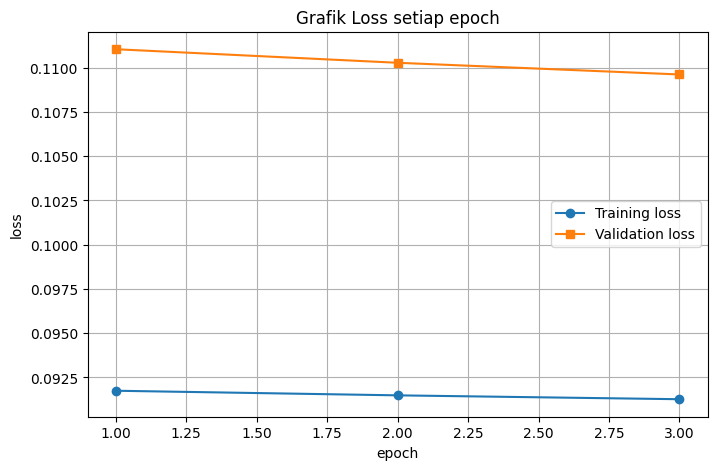

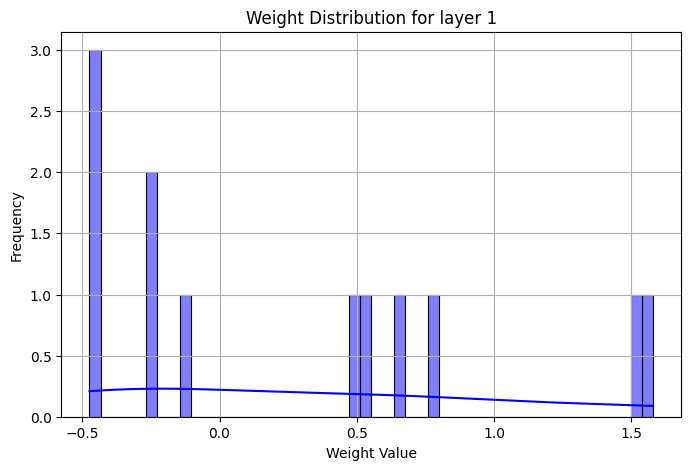

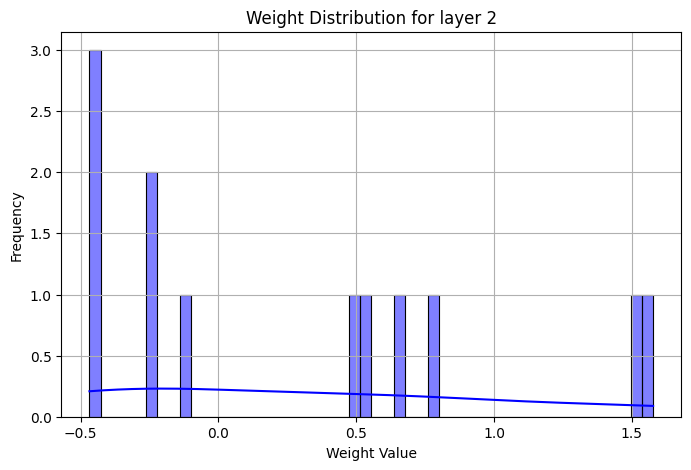

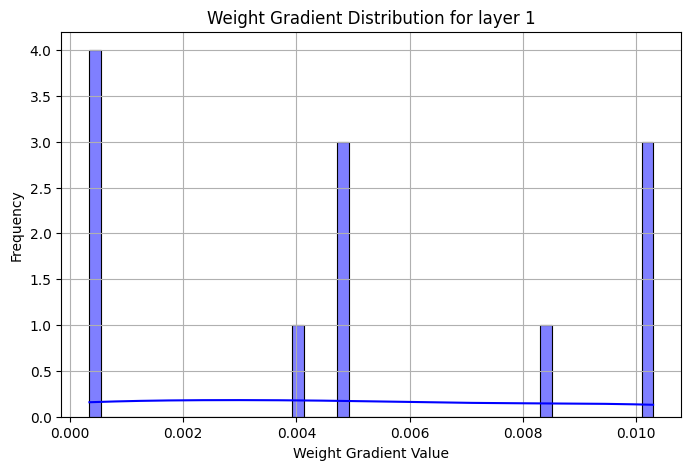

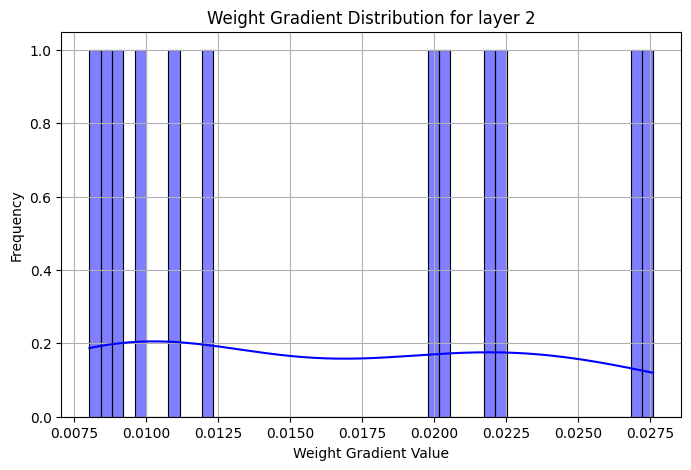

In [26]:
# normal
Weight3 = FFNN(784, [3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("normal", 0, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = Weight3.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = Weight3.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Weight3.weight_distribution([1, 2])
Weight3.gradient_distribution([1, 2])

Epoch 1/3: 100%|██████████| 7/7 [00:04<00:00,  1.54batch/s, Batch Loss=0.0948]


Epoch 1: Train Loss = 0.09081039948242464, Val Loss = 0.08480361521897711


Epoch 2/3: 100%|██████████| 7/7 [00:13<00:00,  1.89s/batch, Batch Loss=0.0942]


Epoch 2: Train Loss = 0.0903773865624078, Val Loss = 0.08513723386487196


Epoch 3/3: 100%|██████████| 7/7 [00:21<00:00,  3.13s/batch, Batch Loss=0.0935]

Epoch 3: Train Loss = 0.08997779497667628, Val Loss = 0.0854970425285696
Prediksi: [3 3]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


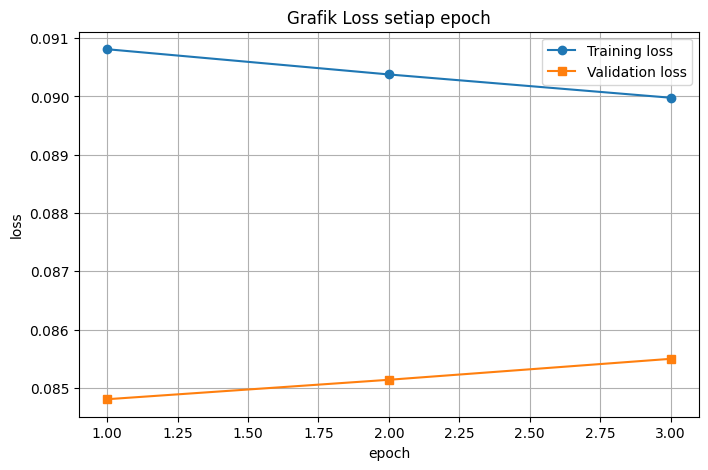

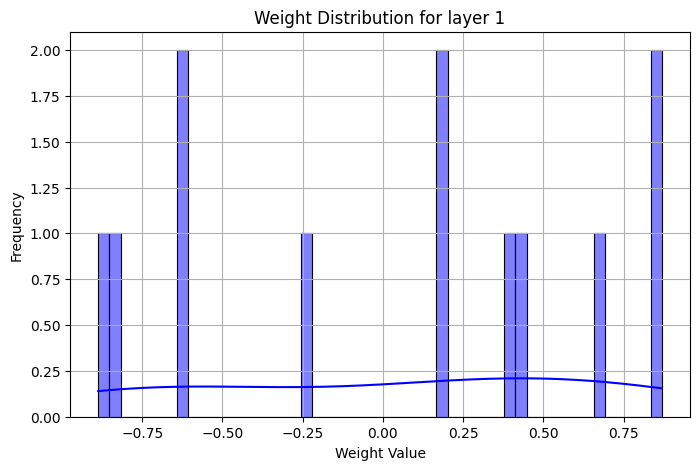

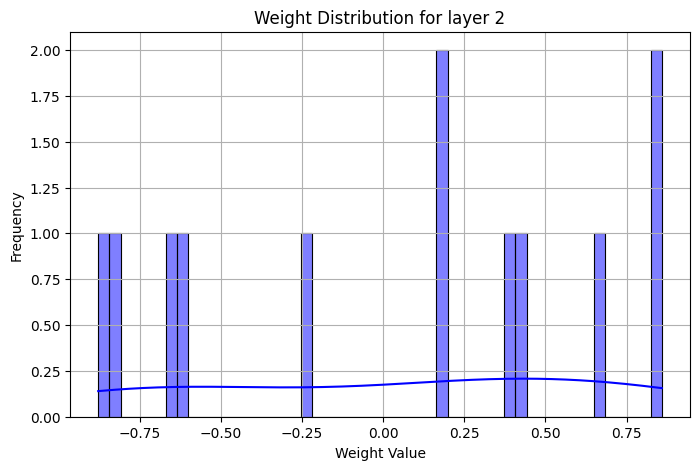

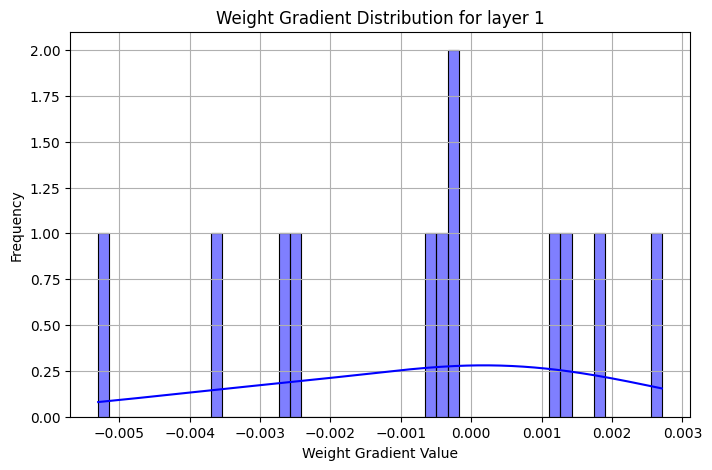

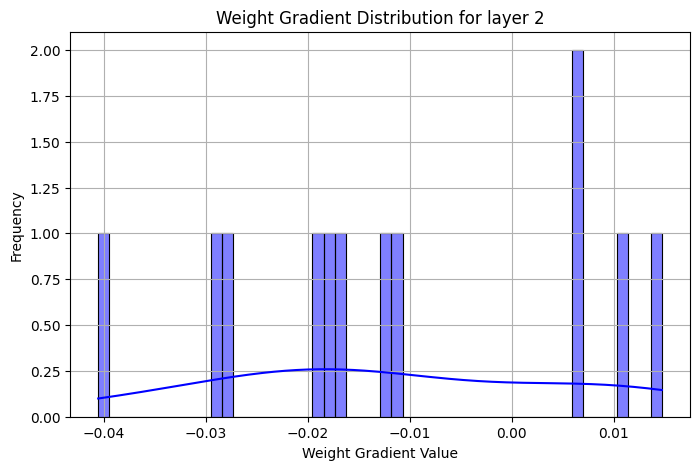

In [27]:
# xavier uniform
Weight4 = FFNN(784, [3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "xavier") for _ in range (4)])
train_loss, val_loss = Weight4.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = Weight4.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Weight4.weight_distribution([1, 2])
Weight4.gradient_distribution([1, 2])

Epoch 1/3: 100%|██████████| 7/7 [00:04<00:00,  1.57batch/s, Batch Loss=0.0755]


Epoch 1: Train Loss = 0.08888770802884875, Val Loss = 0.09658159929350674


Epoch 2/3: 100%|██████████| 7/7 [00:13<00:00,  1.98s/batch, Batch Loss=0.0746]


Epoch 2: Train Loss = 0.08869607695840394, Val Loss = 0.09664454789580203


Epoch 3/3: 100%|██████████| 7/7 [00:21<00:00,  3.11s/batch, Batch Loss=0.0738]

Epoch 3: Train Loss = 0.08851512843998464, Val Loss = 0.09671557121459351
Prediksi: [1 1]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


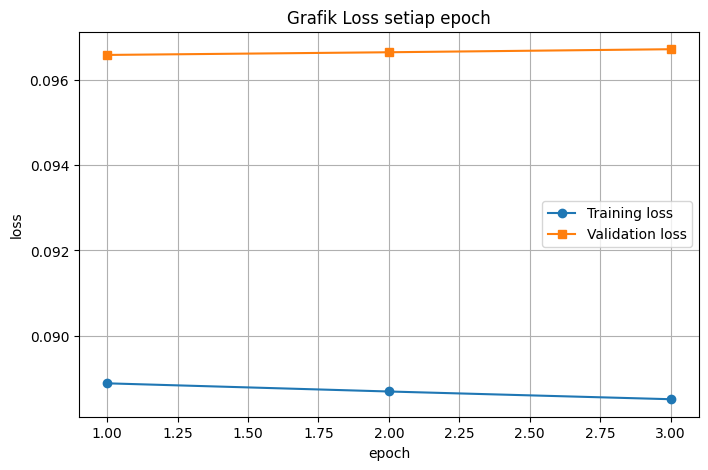

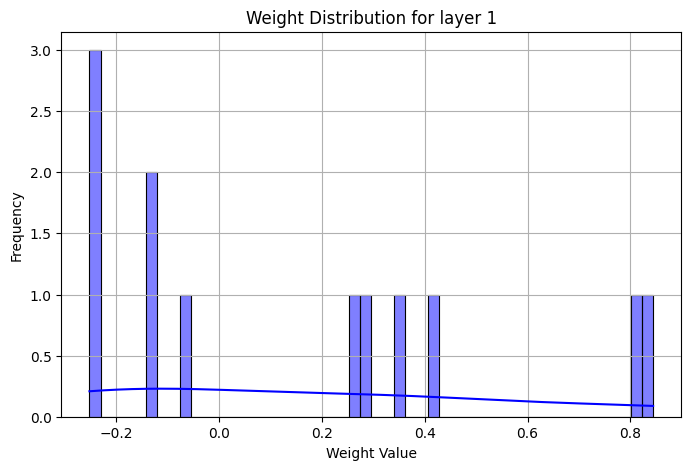

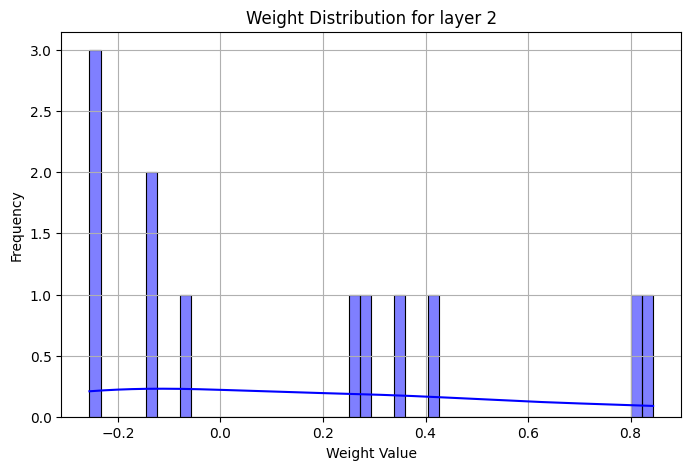

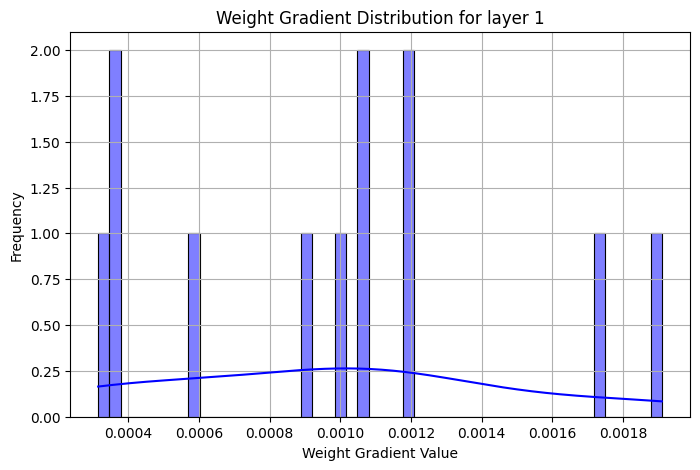

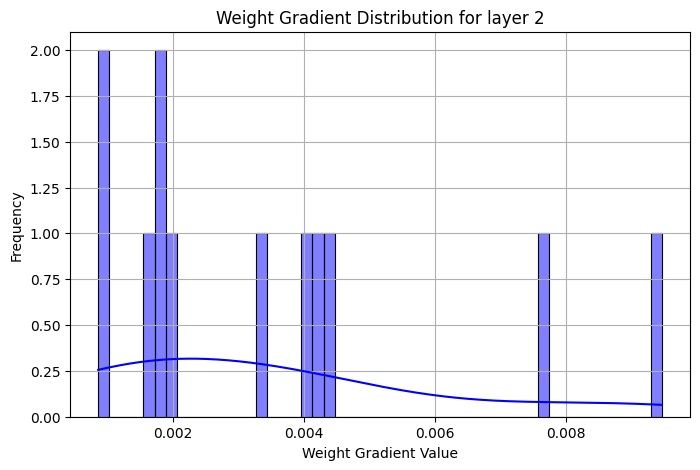

In [28]:
# xavier normal
Weight5 = FFNN(784, [3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("normal", 0, 1, 42, "xavier") for _ in range (4)])
train_loss, val_loss = Weight5.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = Weight5.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Weight5.weight_distribution([1, 2])
Weight5.gradient_distribution([1, 2])

Epoch 1/3: 100%|██████████| 7/7 [00:04<00:00,  1.51batch/s, Batch Loss=0.103] 


Epoch 1: Train Loss = 0.09365981219357095, Val Loss = 0.08184190684885118


Epoch 2/3: 100%|██████████| 7/7 [00:13<00:00,  1.96s/batch, Batch Loss=0.102] 


Epoch 2: Train Loss = 0.09294967280234567, Val Loss = 0.0823426682305923


Epoch 3/3: 100%|██████████| 7/7 [00:22<00:00,  3.21s/batch, Batch Loss=0.101] 

Epoch 3: Train Loss = 0.0923345633078465, Val Loss = 0.08288112138231568
Prediksi: [3 3]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


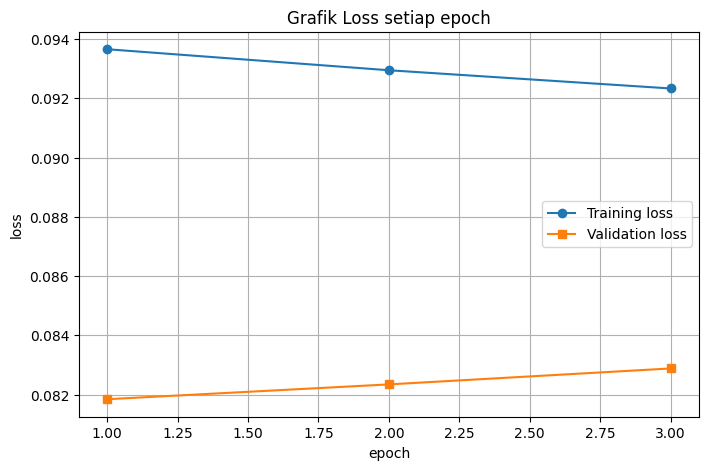

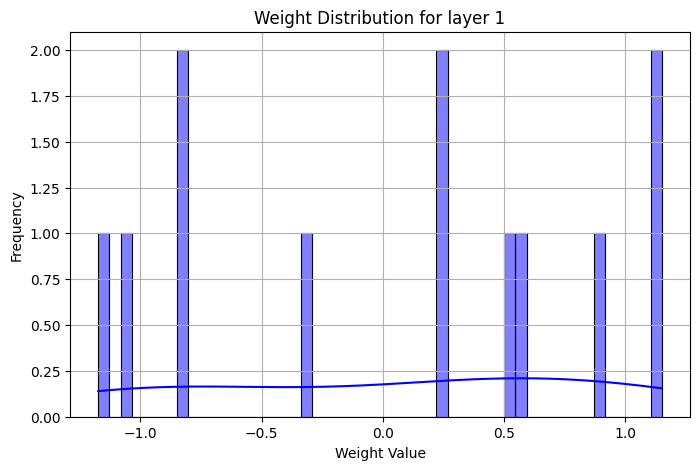

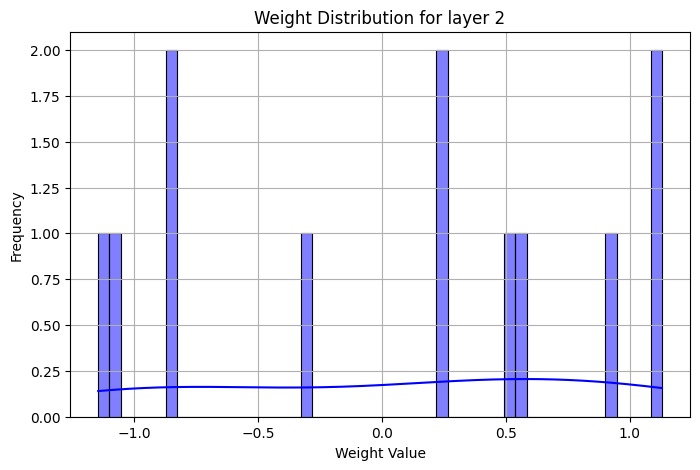

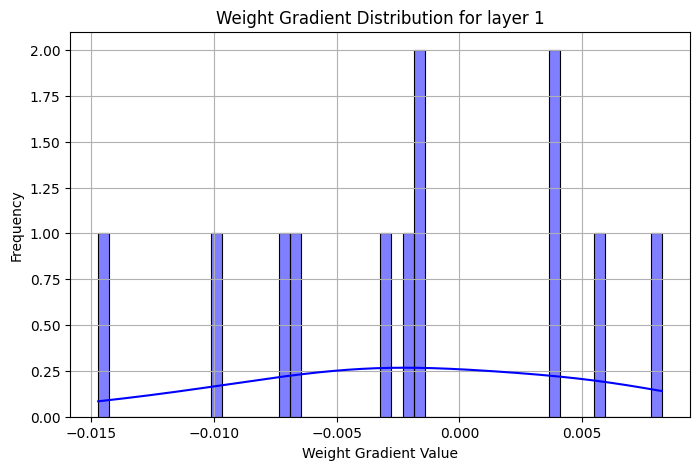

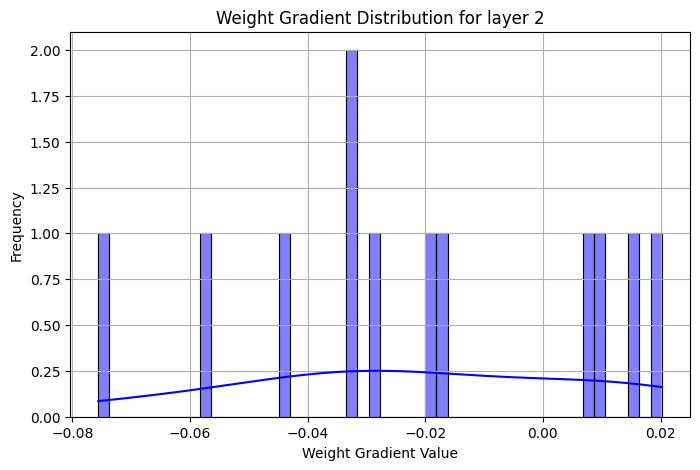

In [29]:
# he uniform
Weight6 = FFNN(784, [3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "he") for _ in range (4)])
train_loss, val_loss = Weight6.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = Weight6.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Weight6.weight_distribution([1, 2])
Weight6.gradient_distribution([1, 2])

Epoch 1/3:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 1/3: 100%|██████████| 7/7 [00:04<00:00,  1.48batch/s, Batch Loss=0.064] 


Epoch 1: Train Loss = 0.0898585782036469, Val Loss = 0.10439848665077696


Epoch 2/3: 100%|██████████| 7/7 [00:14<00:00,  2.04s/batch, Batch Loss=0.064] 


Epoch 2: Train Loss = 0.08973478936635015, Val Loss = 0.10415134141373161


Epoch 3/3: 100%|██████████| 7/7 [06:08<00:00, 52.64s/batch, Batch Loss=0.0639] 


Epoch 3: Train Loss = 0.08961394394163313, Val Loss = 0.1039110987554176
Prediksi: [1 1]
Kelas sebenarnya: [4 5]
Akurasi: 0.0


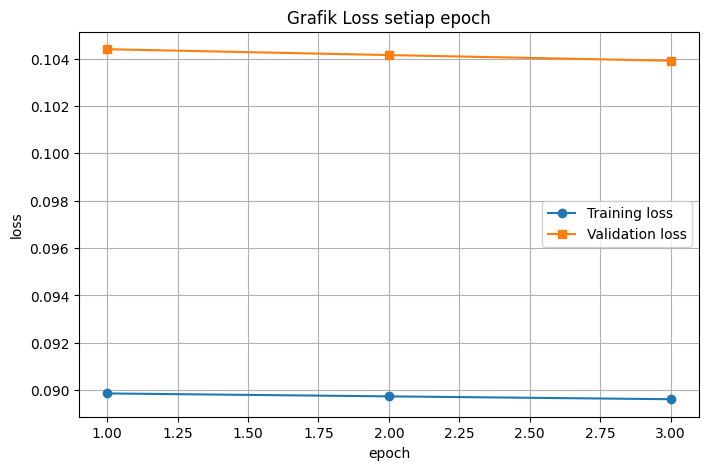

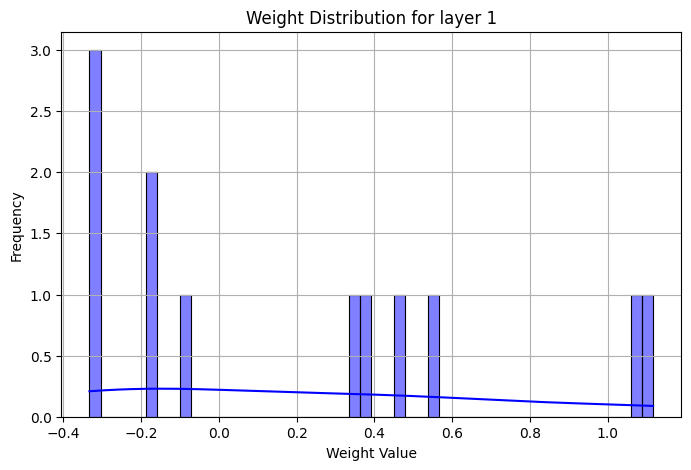

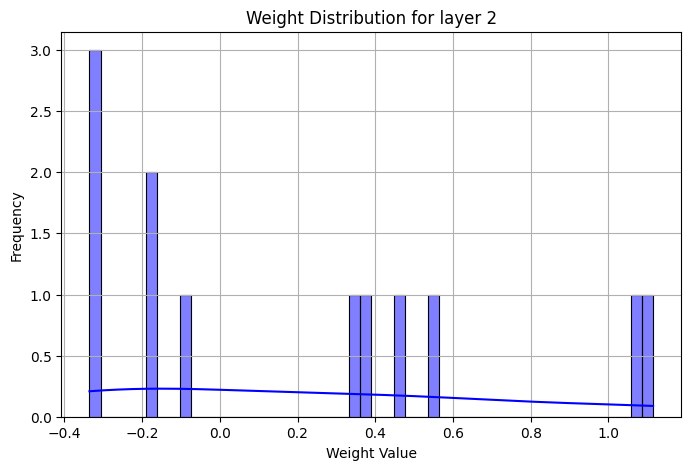

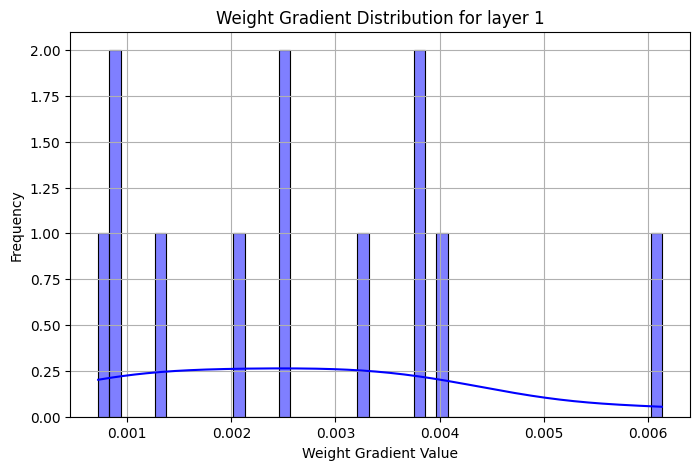

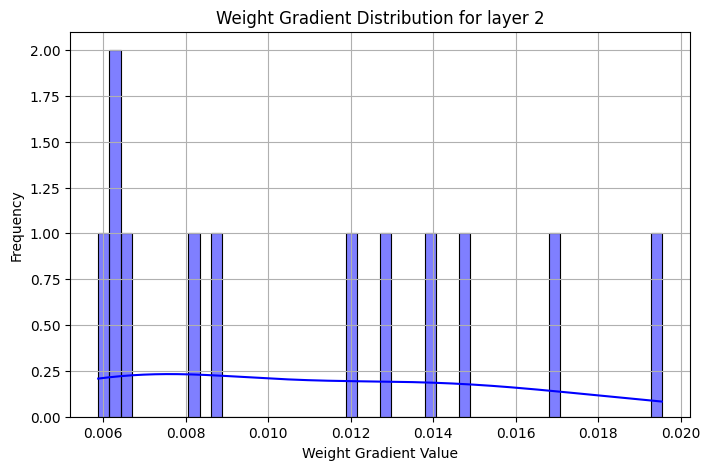

In [30]:
# he normal
Weight7 = FFNN(784, [3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("normal", 0, 1, 42, "he") for _ in range (4)])
train_loss, val_loss = Weight7.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
y_pred = Weight7.predict(X_val)
print("Prediksi:", y_pred)
print("Kelas sebenarnya:", Y_true_value)
print("Akurasi:", accuracy_score(Y_true_value, y_pred))
plot_loss(train_loss, val_loss)
Weight7.weight_distribution([1, 2])
Weight7.gradient_distribution([1, 2])